<a href="https://colab.research.google.com/github/DataAnalyticSscience/business-case-studies/blob/main/Supervised_Machine_Learning_Music_Recommendation_System_Spotify_Part_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Recommendation System Part II**

## **Analysis Background**

### **Context**
---

Music streaming platforms like **Apple Music, Spotify, and Amazon Music** are built to provide listeners with the latest and greatest songs/music. These platforms usually have inventories or libraries of music they can recommend to their listeners at any time.

Similarly, **Echo Nest Music Recording** has provided us with a dataset of songs and other metadata to help them improve customer loyalty and experience.
- To improve customer experience and loyalty, we can build a **recommendation system** to recommend songs to the users based on **their historical interactions with other songs**.
  - This would improve customer experience. Increased customer experience drives **revenue as well as customer loyalty for the company**.

### **Objective**
---

Using the dataset provided,  we will build and test the following recommendation systems, then we will select the best model using KPIs like **`Precision`**, **`Recall`**, and **`F_1 score`** to help **`Echo Nest Music Recording`** improve **`users' experiences`** and **`drive revenue`** for the company.

- **`Rank / Popularity-Based Recommendation Systems`**
- **`User User Similarity-Based Collaborative Filtering`**
- **`Item Item Similarity-based collaborative filtering recommendation systems`**
- **`Model Based Collaborative Filtering - Matrix Factorization`**
- **`clustering-based recommendation systems`**
- **`content-based recommendation systems`**

### **Key Questions**
---

Some of the key questions we are looking to answer include, but are not limited to the following:

- **Which user interacted the most with songs in the dataset?**
- **What is the distribution of the user-song interactions in this dataset?**
- **What are the songs with the most interactions?**

### **The Problem Statement**
---

As stated above, **`Echo Nest Music Recording Company`** has a repository of songs that their customers / listeners can access and play at any given time. We believe that by building a Recommendation System to recommend relevant songs to each user, based on their listening history and that of other users similar to them, we can accomplish the following for the business:
- **`Improve listeners experience`**
- **`Increase listener satisfaction`**
- **`Drive customer / listener loyalty`**
- **`Drive revenue growth for Echo Nest Music Recording Company`**

### **Data Dictionary**
---

To build an actual recommendation system, we will use the modified data we created in part 1 (**df_final**). The new dataframe contains user id, song id, play, title, release, Artist_name, and year. Something to note about the new dataframe is that I added in all the missing years for songs with **0** release year.

df_final now contains:

- **`user _id`** - A unique id given to the user
- **`song_id`** - A unique id given to every song
- **`play_count`** - Number of times the song was played
- **`title`** - Title of the song
- **`release`** - Name of the released album
- **`artist_name`** - Name of the artist
- **`year`** - Year of release (including missing years)

## **Prepare The Environment**

In [66]:
# Install the requisite packages
! pip install surprise

In [67]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# To compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# Performs label encoding
from sklearn import preprocessing

# label_encoder object knows how to understand word labels
label_encoder = preprocessing.LabelEncoder()

In [69]:
# Load the dataset you have saved at the end of milestone 1
df_final = pd.read_csv('/content/drive/MyDrive/ds_datasets/df_final.csv')
df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
1,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
2,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
3,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
4,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007


## **Exploring The Dataset**

Let's explore the dataset and answer some basic data-related questions:

### **Question 1: What is the total number of unique users?**

In [70]:
# Finding number of unique users by using nunique method
print('The number of unique USERS in the final data is ', df_final['user_id'].nunique())

The number of unique USERS in the final data is  3155


### **Questions 2: What is the total number of unique songs?**

In [71]:
# Finding number of unique songs by using nunique method
print('The number of unique SONGS in the final data is ', df_final['song_id'].nunique())

The number of unique SONGS in the final data is  563


**Observations and Insights:**

Here are some observations:
- There are **`563 unique songs`** in the dataset.
- And, given the number of unique users, there is a **`possibility of 3155 * 563 = 1,776,265 play_counts`** in the dataset.

But there are only **`200,396 play_counts`** in our dataset, which means that not every user has played every song in the dataset. **This creates a the possibility of building a recommendation system to recommend songs to the users with which they have not interacted**.


In [72]:
print(563*3155)

1776265


In [73]:
pc = df_final['play_count'].sum()
pc

200396

### **Question 3: Is there any song that has been interacted with more than once by the same user?**

In [74]:
# Finding the frequency of songs rated by each user
df_final.groupby(['user_id', 'song_id']).count()

play_count  title  release  artist_name  year
user_id song_id                                               
11      5158              1      1        1            1     1
        8019              1      1        1            1     1
        8882              1      1        1            1     1
17      314               1      1        1            1     1
        703               1      1        1            1     1
...                     ...    ...      ...          ...   ...
76342   5375              1      1        1            1     1
        7889              1      1        1            1     1
        8494              1      1        1            1     1
        9942              1      1        1            1     1
76347   5879              1      1        1            1     1

[117876 rows x 5 columns]

In [75]:
# Finding the sum of play count by user-song pair
df_final.groupby(['user_id', 'song_id']).count()['play_count'].sum()

117876

- The **`sum is equal to the total number of observations`**, which implies that **there is only one interaction between a pair of a song and a user**.

### **Question 4: Which one is the most interacted song in the dataset?**

In [76]:
# Counting the number of people who have listened to a certain song
df_final['song_id'].value_counts()

8582    751
352     748
2220    713
1118    662
4152    652
       ... 
9048    103
6450    102
990     101
4831     97
8324     96
Name: song_id, Length: 563, dtype: int64

**Observations and Insights:**

The following can be gleaned from the data above:
- The **`song with Id 8582 has been interacted by most users`** which is **`751`** times.
- There is a possibility of **`3155-751 = 2404 more interactions`** as we have **`3155 unique users`** in our dataset.
- For those **`2404 remaining users`**, we can build a recommendation system to predict who is most likely to interact with this song.

Also, out of these **`751 interactions`**, we need to consider the distribution of play_count as well to check whether this song is the most liked song.

In [77]:
print(3155-751)

2404


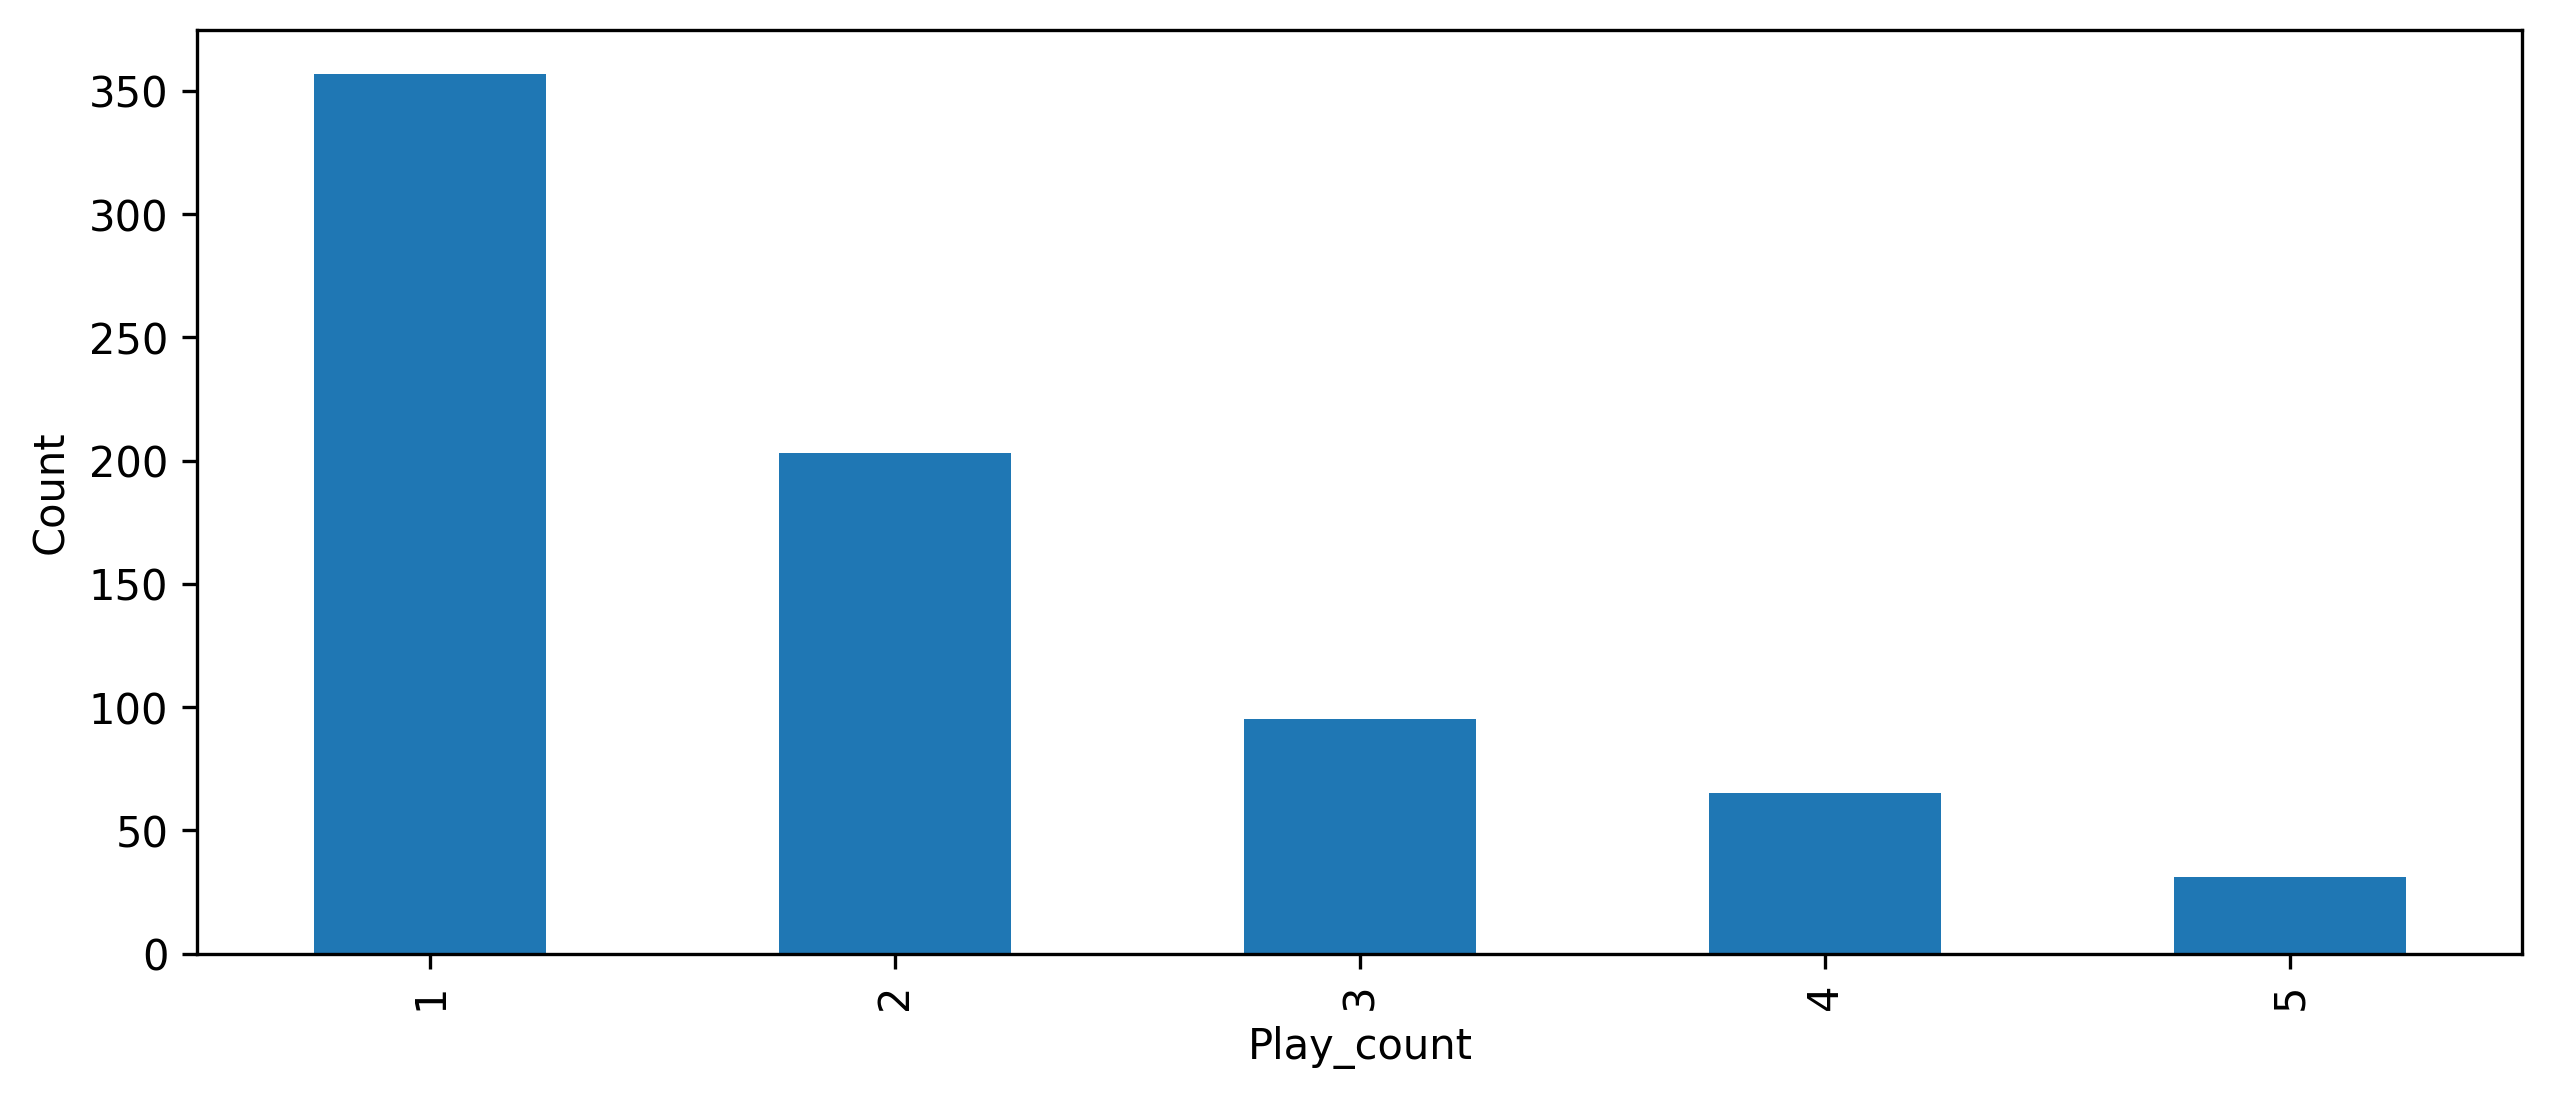

In [78]:
# Plotting distributions of ratings for 751 interactions with sing_id 8582

# Let us fix the size of the figure
plt.figure(figsize = (10, 4), dpi=300)

df_final[df_final['song_id'] == 8582]['play_count'].value_counts().plot(kind = 'bar')

# This gives a label to the variable on the x-axis
plt.xlabel('Play_count')

# This gives a label to the variable on the y-axis
plt.ylabel('Count')

# This displays the plot
plt.show()

**Observations and Insights:**

Based on the chart below, we can infer the following:

- The **`song has been played by the few of the users`**, as the count of `play_count 1 and 2 are higher than the count of lower play_counts`.

- Given that the high `play_counts 1 and 2 are much higher than the count for play_count 4 or 5`, we can assume that most users do not like the song well.

### **Question 5: Which user interacted the most with any song in the dataset?**

In [79]:
# Counting the number of songs each user has listened to
df_final['user_id'].value_counts()

61472    243
15733    227
37049    202
9570     184
23337    177
        ... 
19776      1
45476      1
17961      1
14439      1
10412      1
Name: user_id, Length: 3155, dtype: int64

**Observations and Insights:**

- The user with **`Id: 61472`** has interacted with the most number of songs, i.e., **`243`** times.
- There is a possibility of **`563 - 243 = 320`** more interactions, as we have **`563 unique songs`** in our dataset.
- For those **`320`** remaining songs, we can build a recommendation system to predict which songs are most likely to be listened to by this user.

In [80]:
print(563 - 243)

320


### **Question 6: What is the distribution of the user-song interactions in this dataset?**

In [81]:
# Finding user-movie interactions distribution
play_interactions = df_final.groupby('user_id').count()['song_id']
play_interactions

user_id
11        3
17       34
57       24
84       42
120       7
         ..
76300    37
76307    21
76331    19
76342     8
76347     1
Name: song_id, Length: 3155, dtype: int64

## **Machine Learning Application**

### **Model 1: Rank / Popularity-Based Recommendation System**

**Rank-Based Recommendation Systems** focus on suggesting the most popular items to users.

- This type of system is particularly effective in addressing the **cold start problem**, which arises when a new user joins the platform. In such scenarios, the system lacks historical interaction data for the new user, making personalized recommendations challenging.

- For new users without any interaction history, a rank-based recommendation system can be employed to suggest songs. This approach ensures that even new users receive relevant recommendations based on overall popularity.

  - To construct a **Rank-Based Recommendation System**, we analyze the aggregate play counts of songs. By calculating and ranking songs based on their total play counts, we create a popularity-based recommendation system. This system prioritizes songs that have been played the most across all users, making it a reliable method for initial recommendations, especially for new users.

#### **Step 1: Create Requisite Dataframe**

In [82]:
# Calculating average play_count
average_count = df_final.groupby('song_id').mean()['play_count']       # Hint: Use groupby function on the song_id column

# Calculating the frequency a song is played
play_freq = df_final.groupby('song_id').count()['play_count']        # Hint: Use groupby function on the song_id column

# Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count': average_count, 'play_freq': play_freq})

# # Sort the dataframe by average of ratings in the descending order
# final_play = final_play.sort_values(by = 'play_freq', ascending = False)

# Let us see the first five records of the final_play dataset
final_play.head()

,avg_count,play_freq
song_id,,
21,1.622642,265
22,1.492424,132
52,1.729216,421
62,1.728070,114
93,1.452174,115


Now, let's create a function to find the **`top n songs`** for a recommendation based on the average play count of songs. We can also add a **`threshold for a minimum number of interactions`** for a song to be considered for recommendation.

In [83]:
# Build the function to find top n songs

def top_n_songs(data, n, min_interaction=100):

    # Finding songs with minimum number of play counts
    recommendations = data[data['play_freq'] > min_interaction]

    # Sorting values with respect to average count
    recommendations = recommendations.sort_values(by = 'avg_count', ascending = False)

    return recommendations.index[:n]

We can **`use this function with different n's and minimum interactions`** to get songs to be recommended.

#### **Step 2: Recommending top 10 songs with 50 minimum interactions based on popularity**

In [84]:
# Recommend top 10 songs using the function defined above
list(top_n_songs(final_play, 10, 50))

[7224, 8324, 6450, 9942, 5531, 5653, 8483, 2220, 657, 614]

#### **Step 3: Recommending top 10 songs with 100 minimum interactions based on popularity**

In [85]:
list(top_n_songs(final_play, 10, 100))

[7224, 6450, 9942, 5531, 5653, 8483, 2220, 657, 614, 352]

In [86]:
find_song = df_final[df_final["song_id"] == 7224]
find_song.head(2)

,user_id,song_id,play_count,title,release,artist_name,year
1850,23297,7224,5,Victoria (LP Version),Hit By A Train: The Best Of Old 97's,Old 97's,2006
2037,76307,7224,1,Victoria (LP Version),Hit By A Train: The Best Of Old 97's,Old 97's,2006


**Observations and Insights:**

As we can see from the outputs above, the `top 10 songs with 50 and 100 minimum interactions based on popularity` includes songs like:
- **`Victoria (LP Version), The Big Gundown, Secrets`**, etc.


### **Model 2: User User Similarity-Based Collaborative Filtering**

In this type of recommendation system, **`we do not need any information`** about the user or item. We only need user-item interaction data to build a collaborative recommendation system. For example:
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos, etc.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

In our case, we will be using play count as the ratings equivalent.

**Types of Collaborative Filtering**

- Similarity/Neighborhood-based
 * User-User similarity-based  
 * Item-Item similarity-based
- Model-based

#### **Step 1: Building a baseline user-user similarity based recommendation system**

- Below, we are building a **`similarity-based recommendation system`** using `Pearson` similarity and using **`KNN to find similar users`** which are the nearest neighbor to the given user.  
- We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library.
- Please use the following code to `install the surprise` library. You only do it **`once`** while running the code for the first time.

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

#### **Step 2: Load the requisite surprise library**

In [87]:
# Import necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

#### **Step 3: Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (song in this case) that is actually **rated higher than the threshold rating (here 3.5)** is relevant, and an item that is **actually rated lower than the threshold rating is a non-relevant item**.  

**Recommended item:** An item whose **predicted rating is higher than the threshold (here 3.5) is a recommended item**, and an item whose **predicted rating is lower the threshold rating is a non-recommended item**, i.e., it will not be recommended to the user.  

**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user, then recall is 0.60. Higher the value of recall, better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user, then precision is 0.60. The higher the value of precision, better is the model. It is one of the metrics to do the performance assessment of classification models.

**When building a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

#### **Step 4: Precision@k, Recall@ k, and F1-score@k**

**`Precision@k`** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**`Recall@k`** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**`F1-score@k`** - It is the **`harmonic mean of Precision@k and Recall@k`**. When **`precision@k and recall@k both seem to be important`**, it is useful to use this metric because it is representative of both of them.

#### **Step 5: Some useful functions**

Below is the function to calculate **`precision@k and recall@k, RMSE and F1_Score@k`** to evaluate the model performance.
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [88]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

- To compute **precision and recall**, a **threshold of 1.5 and k value of 30 is taken for the recommended and relevant ratings**.
- In this case, **precision and recall**, both need to be optimized as the service provider would like to minimize both the losses discussed above. Hence, the correct performance measure is the **F_1 score**.

#### **Step 6: Create The Rating Scale Required By The Surprise Library**

Below we are converting the **`rating` dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`**. This is required by the surprise library. To do this, we will be **using the classes `Reader` and `Dataset`**.

In [89]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5)) #use rating scale (0, 5)

# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader) # Take only "user_id","song_id", and "play_count"

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.40, random_state = 42) # Take test_size = 0.4

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.
- **KNNBasic** is an algorithm that is also **associated with the surprise package**. It will be used to find the **similar songs among a given set of songs**.

#### **Step 7: Building the baseline user-user similarity based model**

In [90]:
# Build the baseline user-user-similarity model

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1) # Use random_state = 1

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
precision_recall_at_k(sim_user_user, k = 30) # Use sim_user_user model

RMSE: 1.0878
Precision:  0.396
Recall:  0.692
F_1 score:  0.504


**Observations and Insights:**

- A **`RMSE`** has been calculated to check **`how far the overall predicted play_count`** are from the **`actual play_count`**.
- Intuition of Recall: We are getting a **`recall of ~0.69`**, which means out of **`all the relevant songs, 69% are recommended`**.
- Intuition of Precision: We are getting a **`precision of ~ 0.40`**, which means **`out of all the recommended songs, 40% are relevant`**.
- Here **`F_1 score`** of the **`baseline model is ~0.50`**. It indicates that **`mostly recommended songs were relevant and relevant songs were recommended`**.

#### **Step 8: Predicting Ratings for a User-Song Pairing Using Baseline Model**

Let's **predict the rating for the user with `user_id = 6958` and the song with `song_id = 1671`**. Here, the user has already interacted or listened to the song.

In [91]:
# Predicting play_count for a sample user with a listened song
sim_user_user.predict(6958, 1671, r_ui = 2, verbose = True) # Use user id 6958 and song_id 1671

user: 6958       item: 1671       r_ui = 2.00   est = 1.80   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.8009387435128914, details={'actual_k': 40, 'was_impossible': False})

Let's now **predict the rating for the same, but for a song they have not listened to**, which is **`user_id = 3232`**.

In [92]:
# Predicting play_count for a sample user with a song not-listened by the user
sim_user_user.predict(6958, 3232, verbose = True) # Use user_id 6958 and song_id 3232

user: 6958       item: 3232       r_ui = None   est = 1.64   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.6386860897998294, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**

Here's what we observed directly above:
- In the first scenario, **the actual play_count for this user-item pair is 2, and the predicted play_count is 1.80** using a **`user-user-similarity-based baseline model`**.
- In the second scenario, **the actual play count is undetermined, but the predicted play count is 1.64`** using the same model.
- Both ratings are close enough to the actual rating of 2, so we can say that our model is doing a good job thus far, but there's room for improvement.

#### **Step 9: Improving similarity-based recommendation system by tuning its hyperparameters**

- **k** (int): The (max) number of neighbors to take into account for aggregation. The default value of k is 40.
- **min_k** (int): The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. The default value is 1.
- **sim_options** (dict): A dictionary of options for the similarity measure. And there are four similarity measures available in surprise:
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

**Note:** GridSearchCV does not accept the metrics recall@k, precision@k, or F1 Score@k. As a result, we'll tune the model using RMSE.

Now, let's try to tune the model and see if we can improve the model performance.

##### **9.1: Setting up hyperparameters tuning**

In [93]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [True], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data) # Use entire data for GridSearch

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.0465111761565093
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


Now that the grid search is **`complete`**, let's use **`optimal values for each of those hyperparameters`** to improve the model below.

##### **9.2: Improve the Baseline User-User Model**

Now, let's build the **`final model by using the optimal values of the hyperparameters`**, which we received by using the **`grid search cross-validation`**.

In [94]:
# Train the best model found in above gridsearch
sim_options = {'name': 'pearson_baseline',
               'user_based': True,
               'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0521
Precision:  0.413
Recall:  0.721
F_1 score:  0.525


**Observations and Insights:**

Based on the results of our model above, we observed the following:

- after **tuning hyperparameters**, **F_1 score of the tuned model is 0.53, which is slightly better than the baseline model (0.50)**.
- The **RMSE (1.05) of the model has also decreased compared to the model before hyperparameter tuning (1.09)**.
- Recall also improved from **`0.69`** to **`0.72`**

Based on some of these observations, **`we can with a level of certainty say that the model performance has improved slightly after hyperparameter tuning`**.

#### **Step 10: Predicitng Ratings for a User-Song Pairing Using Optimized Model**

Let us now **predict the rating for the user with `user_id = 6958` and the song with `song_id = 1671` using the optimized model**.

In [95]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
sim_user_user_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 24, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.962926073914969, details={'actual_k': 24, 'was_impossible': False})

Below, let's predict the rating for the same **`user_id = 6958`** but for a song with which this user has **`not interacted before`**, i.e., `song_id = 3232`, using the **optimized model**.

In [96]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)
sim_user_user_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.45   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4516261428486725, details={'actual_k': 10, 'was_impossible': False})

**Observations and Insights:**

When we compare the predicted play count with the actual play count, we see the following:

- There are **`noticeable improvements in the predicted play counts when compared to that of the baseline model`**.
- For the song the user has not listened to, The baseline model seems to be doing a better job predicting the rating.

#### **Step 11: Identifying similar users to a given user (nearest neighbors)**

We can also find out **`similar users to a given user`** or its **`nearest neighbors`** based on this KNNBasic algorithm. Below, we are finding **the 5 most similar users to `user_id = 6958`** based on the **`msd` distance metric**.

In [97]:
# Use inner id 0
sim_user_user_optimized.get_neighbors(0, k = 5)

[42, 1131, 17, 186, 249]

The ids that are most similar to user 0 using the msd distance metric are as follows:
- Users 42, 1131, 17, 186, and 249

#### **Step 12: Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [98]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(index = 'user_id', columns = 'song_id', values = 'play_count')

    # Extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x : x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

#### **Step 13: Predicted top 5 songs for userId = 6958 using the similarity-based recommendation system.**

In [99]:
# Make top 5 recommendations for user_id 6958 with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, sim_user_user_optimized)

In [100]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,5531,2.553335
1,317,2.518269
2,4954,2.406776
3,8635,2.396606
4,5943,2.390723


**Observations and Insights:**

Based on our predictions, the top five (5) songs for user 6958 are as follows:
- `5531`, `317`, `4954`, `8635`, and `5943`
- all of these songs have a predicted ratings of `2.4` and `2.6`

#### **Step 14: Correcting the Ratings and Ranking the above songs**

While comparing the play counts of two songs, it is not only the **`play_count`** that describe the **`likelihood of the user interacting with that song`**.
- The **`number of users who have listened to that song`** is also become important.
  - Due to this, we have calculated the **"corrected_ratings"** for each song. Generally, the higher the **`rating_count of a song, the more reliable the rating is`**.
  - To interpret the above concept, a **`movie rated 4 with rating_count 3 is less liked in comparison to a movie rated 3 with a rating count of 50`**.
  - It has been **`empirically found that the likelihood of the movie is directly proportional to the inverse of the square root of the rating_count of the movie`**.

In [101]:
def ranking_songs(recommendations, final_rating):
  # Sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending = False)[['play_freq']].reset_index()

  # Merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings']), on = 'song_id', how = 'inner')

  # Rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_ratings'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # Sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending = False)

  return ranked_songs

**Note:** In the **`above-corrected rating formula`**, we can add the **quantity `1/np.sqrt(n)` instead of subtracting it to get more optimistic predictions**. But here we are **subtracting this quantity**, as there are some songs with ratings of 5 and **we can't have a rating more than 5 for a song**.
- What we are trying to do is penalize the rating of each song; so if the rating is lower, the penalty is higher for the song.

In [102]:
# Applying the ranking_songs function on the final_play data
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
0,5531,618,2.553335,2.513109
2,317,411,2.518269,2.468943
1,5943,423,2.390723,2.342101
3,4954,183,2.406776,2.332854
4,8635,155,2.396606,2.316284


**Observations and Insights:**

We can now see the **`predicted_ratings`** vs the **`corrected_ratings`** for the top five songs for user `6958`.

### **Model 3: Item-Item Similarity-Based Collaborative Filtering Recommendation Systems**

We have seen **`user-user similarity-based collaborative filtering`**. Now, let us look into **`similarity-based collaborative filtering`** where similarity is computed **`between items`**.

#### **Step 1: Building The Baseline Item-Item Similarity Based Model**

In [103]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance

# Declaring the similarity options
sim_options = {'name': 'pearson',
               'user_based': False}

# The KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0588
Precision:  0.376
Recall:  0.538
F_1 score:  0.443


**Observations and Insights:**

As you can see:
- The **`F_1 score`** of the **`baseline model`** is **~0.44**. Let's try to improve this value by `tuning different hyperparameters` the algorithm using **`GridSearchCV`**.
- This is a worst F_1 score relative to the user-user model (~0.50)

#### **Step 2: Predicitng Ratings for a User-Song Pairing Using Baseline Item-Item Model**

Let's now **predict the rating for the user with `userId = 6958` and the song with `song_id = 1671`**. The user has already listened to the song.

In [104]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user
sim_item_item.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.92   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.91669781984001, details={'actual_k': 10, 'was_impossible': False})

Let's now **predict the rating for the same, but for a song they have not listened to**, which is **`user_id = 3232`**.

In [105]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)
sim_item_item.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.00   {'actual_k': 5, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.0, details={'actual_k': 5, 'was_impossible': False})

**Observations and Insights:**

- While the F_1 score for the baseline item-item model is lower than that of the user-user model, the item-item model is doing a slightly better job predicting the rating for our user.
- But as we can see, the same model is doing a poorer job predicting rating for a song the user has not played before.

#### **Step 3: Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be **tuning hyperparameters of the `KNNBasic` algorithm**.

In [106]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [False], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Extract the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0222902690252154
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


Once the **`grid search`** is complete, we can get the **`optimal values for each of those hyperparameters as shown above`**.

#### **Step 4: Improve the Baseline Item-Item Model**

Now, let's build the model using the **`optimal values of the hyperparameters`**, from  the **`grid search cross-validation`**.

In [107]:
# Apply the best modle found in the grid search
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': False,
               'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.0328
Precision:  0.408
Recall:  0.665
F_1 score:  0.506


**Observations and Insights:**

- After **`tuning hyperparameters`**, **`F_1 score (~0.51) of the model is better than the baseline model (~0.40)`**.
- The **`RMSE of the model (~1.03) has decreased slightly in comparison to the model with default hyperparameters`**.
- Based on these observations, we can say with a level of certaintly, that `the model performance has improved after hyperparameter tuning`.

#### **Step 5: Predicitng Ratings for a User-Song Pairing Using Optimized Item-Item Model**

Let's now predict the **rating for the user with `userId = 6958` and the song with `song_id = 1671`** using the **`optimized model`** as shown below.

In [108]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
sim_item_item_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.9634957386781853, details={'actual_k': 10, 'was_impossible': False})

Let's now **predict the rating for the same, but for a song they have not listened to**, which is **`user_id = 3232`**.

In [109]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user
sim_item_item_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.28   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2759946618244609, details={'actual_k': 10, 'was_impossible': False})

**Observations and Insights:**

- The predicted rating by the optimized model was closer to the actual rating in comparison to that by the baseline model.
- Tuning the baseline model definitely helped improve our predictions

#### **Step 6: Identifying similar items to a given item (nearest neighbors)**

We can also find out **`similar items`** to a given item or its nearest neighbors based on this **`KNNBasic algorithm`**. Below, we are finding the 5 most similar items to `ItemId = 0` based on the `msd` distance metric.

In [110]:
# Find five most similar items to the item with inner id 0
sim_item_item_optimized.get_neighbors(0, k = 5)

[124, 523, 173, 205, 65]

In [111]:
sim_user_user_optimized.get_neighbors(0, k = 5)

[42, 1131, 17, 186, 249]

As you can see, we are going to get different results based on the model we are using.

#### **Step 7: Predicting top 5 songs for user_id = 6958 using the similarity-based recommendation system.**

In [112]:
# Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)

In [113]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,2342,2.653903
1,5101,2.386577
2,139,2.313727
3,7519,2.270864
4,8099,2.212702


#### **Step 8: Correcting the Ratings and Ranking the above songs**

In [114]:
# Applying the ranking_songs function
ranking_songs(recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
4,2342,111,2.653903,2.558987
2,5101,130,2.386577,2.298871
3,139,119,2.313727,2.222057
1,7519,168,2.270864,2.193712
0,8099,275,2.212702,2.152399


**Observations and Insights:**

We can now see the **`predicted_ratings`** vs the **`corrected_ratings`** for the top five songs for user `6958`.

### **Model 4: Model Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### **Step 1: Building The Baseline SVD Model**

In [115]:
# Build baseline model using svd

# Using SVD with matrix factorization
svd = SVD(random_state = 1)

# Training the algorithm on the training dataset
svd.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd)

RMSE: 1.0252
Precision:  0.41
Recall:  0.633
F_1 score:  0.498


**Observations and Insights:**

As you can see:
- The **`F_1 score`** of the **`baseline svd model`** is **~0.50**. We will see how that compares to the optimized model.
- The RMSE of the model is 1.0252

#### **Step 2: Predicitng Ratings for a User-Song Pairing Using the Baseline SVD Model**

Predicting rating for user (with user_id 6958) to song (with song_id 1671)

In [116]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.27   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.267473397214638, details={'was_impossible': False})

Predicting rating for the same user who has not listened to the song (song_id 3232)

In [117]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
svd.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.56   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.5561675084403663, details={'was_impossible': False})

**Observations and Insights:**

As you can see:
- The predicted rating 1.27 using the baseline **`matrix factorization-based model`** is not up to par with the actual rating. We will try and fixed that by tunning the model below.

Now, let's move on to improving the matrix factorization based recommendation system by tuning its hyperparameters.

#### **Step 3: Improve the Baseline SVD Model**

In [118]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performe 3-fold grid-search cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0128259282273935
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [119]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(svd_optimized)

RMSE: 1.0141
Precision:  0.415
Recall:  0.635
F_1 score:  0.502


**Observations and Insights:**

- After **`tuning hyperparameters, the model performance has improved ever so slightly`**, but not by any significant percentage.
- We went from an F_1 score of  0.498 in the baseline model, to an F_1 score of 0.502 in the optimized model.

#### **Step 4: Predicitng Ratings for a User-Song Pairing Using the Baseline SVD Model**

Using the svd_algo_optimized model, let's predict the rating for user_id 6958 and song_id 1671.

In [120]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
svd_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.34   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.3432395286125098, details={'was_impossible': False})

Similarly, let predict the rating for a song the user has not listened to...

In [121]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
svd_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.44   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4425484461176483, details={'was_impossible': False})

**Observations and Insights:**

The optimized model was slightly better at rating songs compared to the baseline model.

#### **Step 5: Predicting Top 5 Songs Using the SVD Recommendation System**

In [122]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, 6958, 5, svd_optimized)

In [123]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(svd_recommendations, columns = ['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,7224,2.601899
1,5653,2.108728
2,8324,2.014091
3,6450,1.952493
4,9942,1.940115


#### **Step 6: Correcting the Ratings and Ranking for the Above Songs**

In [124]:
# Ranking songs based on above recommendations
ranking_songs(svd_recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
2,7224,107,2.601899,2.505225
1,5653,108,2.108728,2.012502
4,8324,96,2.014091,1.912029
0,9942,150,1.940115,1.858465
3,6450,102,1.952493,1.853478


**Observations and Insights:**

We now have the corrected and predicted ratings for the top 5 songs using the optimized SVD model.

### **Model 5: Cluster-Based Recommendation System**

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

#### **Step 1: Building the Baseline Cluster Model**

In [125]:
# Make baseline clustering model

# Using CoClustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(clust_baseline)

RMSE: 1.0487
Precision:  0.397
Recall:  0.582
F_1 score:  0.472


**Observations and Insights:**

As you can see:
- The **`F_1 score`** of the **`baseline cluster model`** is **~0.47**. We will see how that compares to the optimized model.
- The RMSE of the model is 1.0487

#### **Step 2: Predicitng Ratings for a User-Song Pairing Using the Baseline Cluster Model**

Predicting ratings for user_id 6958 and song_id 1671

In [126]:
# Making prediction for user_id 6958 and song_id 1671
clust_baseline.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.29   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.2941824757363074, details={'was_impossible': False})

Predicting ratings for user_id 6958 and song_id 3232

In [127]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user
clust_baseline.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.48   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4785259100797417, details={'was_impossible': False})

**Observations and Insights:**
- Estimated play counts for both songs are not as closed to the actual rating, which means that our model could be further improved.

Now, let's move on to improving the clustering-based recommendation system by tuning its hyperparameters.

#### **Step 3: Improve the Baseline Cluster Model**

In [128]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [5, 6, 7, 8], 'n_cltr_i': [5, 6, 7, 8], 'n_epochs': [10, 20, 30]}

# Performing 3-fold grid search cross-validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0625313546919628
{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 10}


Once GSCV is complete, we will use the output to improve our baseline model.

In [129]:
# Train the tuned Coclustering algorithm

# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 5, n_cltr_i = 5, n_epochs = 10, random_state = 1)

# Training the algorithm on the train set
clust_tuned.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0654
Precision:  0.394
Recall:  0.566
F_1 score:  0.465


**Observations and Insights:**

- We can see that the F_1 score for `tuned co-clustering model` **0.465** is slightly lower compared to the F_1 score **0.472** for the `baseline Co-clustering model`.
- So we did not make any improvements by tuning the baseline model

#### **Step 4: Predicitng Ratings for a User-Song Pairing Using the Optimized Cluster Model**

Let's now **`predict the rating`** for the user with `userId = 6958` and for the song with `song_id = 1671` as shown below. Here, the user has already rated the song.

In [130]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
clust_tuned.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.91   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.9108882530486497, details={'was_impossible': False})

Below, we are predicting the rating for the same `user_id = 6958` but for a song with which this user has not interacted before, i.e., `song_id = 3232`, as shown below.

In [131]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
clust_tuned.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.24   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2366916027865822, details={'was_impossible': False})

**Observations and Insights:**

- While the `F_1 score` for the tuned model is `slightly lower`, it's doing a better job `predicting ratings` compared to the `baseline model`.

#### **Step 5: Implementing the recommendation algorithm based on optimized CoClustering model**

In [132]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(df_final, 6958, 5, clust_tuned)

In [133]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(clustering_recommendations, columns = ['song_id', 'predicted_ratings'])

,song_id,predicted_ratings
0,7224,3.711503
1,5653,2.903883
2,6860,2.691043
3,657,2.606354
4,8483,2.582807


In [134]:
find_song = df_final[df_final["song_id"] == 6860]
find_song.head(2)

,user_id,song_id,play_count,title,release,artist_name,year
1102,60910,6860,2,Mercy:The Laundromat,Westing (By Musket and Sextant),Pavement,1993
2141,27729,6860,2,Mercy:The Laundromat,Westing (By Musket and Sextant),Pavement,1993


The top 5 songs based on the cluster model recommendation in includes the following:

- Victoria (LP Version), Transparency, Mercy:The Laundromat, etc.

#### **Step 6: Correcting the Ratings and Ranking for the Above Songs**

In [135]:
# Ranking songs based on the above recommendations
ranking_songs(clustering_recommendations, final_play)

,song_id,play_freq,predicted_ratings,corrected_ratings
4,7224,107,3.711503,3.614829
3,5653,108,2.903883,2.807658
0,6860,169,2.691043,2.614120
1,657,151,2.606354,2.524975
2,8483,123,2.582807,2.492640


**Observations and Insights:**

The cluster based model allows us to see the **`predicted_ratings`** vs the **`corrected_ratings`** for the top five songs for user `6958`.

Let us now move to the final recommendation algorithm, **`Content-based recommendation system`**.

### **Model 6: Content-Based Recommendation System**

#### **Step 1: Define The Requisite Dataframe**

In [136]:
df_small = df_final

In [137]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title'] + ' ' + df_small['release'] + ' ' + df_small['artist_name']

df_small.head()

,user_id,song_id,play_count,title,release,artist_name,year,text
0,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And Prudence Distillation Erin McKeown
1,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael Valentine Sawdust The Ki...
2,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,I Stand Corrected (Album) Vampire Weekend Vamp...
3,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,They Might Follow You Tiny Vipers Tiny Vipers
4,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,Monkey Man You Know I'm No Good Amy Winehouse


Now, we will keep only the columns we need -- title, user_id, song_id,play_count, and text. We will then drop duplicate titles from the data and make the title column as the index.

#### **Step 2: Refine The Dataframe**

In [138]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]

# Drop the duplicates from the title column
df_small = df_small.drop_duplicates(subset = ['title'])

# Set the title column as the index
df_small = df_small.set_index('title')

# See the first 5 records of the df_small dataset
df_small.head()

,user_id,song_id,play_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And Prudence Distillation Erin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael Valentine Sawdust The Ki...
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album) Vampire Weekend Vamp...
They Might Follow You,6958,703,1,They Might Follow You Tiny Vipers Tiny Vipers
Monkey Man,6958,719,1,Monkey Man You Know I'm No Good Amy Winehouse


In [139]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)
indices[ : 5]

0                 Daisy And Prudence
1    The Ballad of Michael Valentine
2          I Stand Corrected (Album)
3              They Might Follow You
4                         Monkey Man
Name: title, dtype: object

#### **Step 3: Loading Natural Language Processing Toolkit**

The handle the text forward that we now have.

In [140]:
# Importing necessary packages to work with text data
import nltk

# Download punkt library
nltk.download("punkt")

# Download stopwords library
nltk.download("stopwords")

# Download wordnet
nltk.download("wordnet")

# Download omw-1.4
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [141]:
# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### **Step 4: Create Function to Pre-process The Text Data:**

In [142]:
# Function to tokenize the text
def tokenize(text):

    text = re.sub(r"[^a-zA-Z]"," ", text.lower())

    tokens = word_tokenize(text)

    words = [word for word in tokens if word not in stopwords.words("english")]  # Use stopwords of english

    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

#### **Step 5: Feature Extraction**

Below are some of the ways to extract features from texts:
- Bag of words
- TF-IDF
- One hot encoding
- Word vectors

In [143]:
# Create tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer = tokenize)

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array
song_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

# Making the DataFrame of song_tfidf data
pd.DataFrame(song_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
len(tfidf.get_feature_names_out())

1437

We have extracted features from the text data. Now, we can find similarities between songs using these features. We will use **cosine similarity** to calculate the similarity.

#### **Step 6: Compute Similarity Using Cosine**

In [145]:
# Compute the cosine similarity for the tfidf above output

# Calculating the cosine similarity
similar_songs = cosine_similarity(song_tfidf, song_tfidf)
# Let us see the above array
similar_songs

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

 Finally, let's create a function to find most similar songs to recommend for a given song.

#### **Step 7: Create a Function to Find the Most Similar Songs**

In [146]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):

    recommended_songs = []

    # Getting the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # Getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1 : 11].index)
    print(top_10_indexes)

    # Populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])

    return recommended_songs

#### **Step 8: Recommending 10 Songs Similar to Learn to Fly**

In [147]:
# Make the recommendation for the song with title 'Learn To Fly'
recommendations('Learn To Fly', similar_songs)

[509, 234, 423, 345, 394, 370, 371, 372, 373, 375]


['Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Under The Gun',
 'I Need A Dollar',
 'Feel The Love',
 'All The Pretty Faces',
 'Bones']

**Observations and Insights:**

Here's what the we learned from the recommender:
- The song belongs to **`Hard Rock`** genre, and the **majority of our recommendations** fall within this genre.
- This is an `indication that the resulting recommendation system is working well`.

## **Conclusion and Recommendations:**

### **Conclusions**
---

We set out to build a recommendation system that would allow the **`Echo Nest Music Recording Company`** accomplish the following:

- **`Improve listeners experience`**
- **`Increase listener satisfaction`**
- **`Drive customer / listener loyalty`**
- **`Drive revenue growth for Echo Nest Music Recording Company`**

As part of this analysis, we built the five recommendation systems listed below:

- **`Rank / Popularity-Based Recommendation Systems`**
- **`User User Similarity-Based Collaborative Filtering`**
- **`Item Item Similarity-based collaborative filtering recommendation systems`**
- **`Model Based Collaborative Filtering - Matrix Factorization`**
- **`clustering-based recommendation systems`**
- **`content-based recommendation systems`**

Some of the key components of these models employed include, but are not limited to the following:

- The **`surprise`** library
- **`Grid search cross-validation`** was applied to find the best working model, with the best corresponding predictions
- **precision@k and recall@k** were used to evaluate the performance of these models
- **`F_1 score`** to calculate performance for each working model
- We employed **`hyperparameter tuning`** to in an attempt to improve the performance of the models

### **Recommendations for the Business:**
---

**Recommendations for the Business:**

Each of the models we build have their merits, and may work well in different scenarios. In advising the Echo Nest Music Recording Company, we would recommend they deploy the various models in the following scenarios:


- **`Rank / Popularity-Based Recommendation Systems`**
  - There are cohorts of users who are apt to consume content based on popularity. These users are more likely to benefit from songs recommended by a popularity based model.

- **`User User Similarity-Based Collaborative Filtering`**
  - After evaluating the ability of both the user-user and item-item models, I'm more confident that the user-user model (based on the higher F_1 score) will do a better job recommending songs to listeners who don’t necessarily follow the crowd (popularity based model), and may prefer recommendations based on their past histories.

- **`content-based recommendation systems`**
  - There’s also an opportunity to leverage a content based model as well. The content based model might offer the most upside for the level investment it would require to deploy, and did a fantastic job recommending songs similar to our seed song **“Learn To Fly”**. For those users who are genre specific, this could be the perfect solution.

Taking deployment cost and business prioritizations into consideration, my recommendation would be that Echo Nest deploy each of these models to address different sectors of their business or consumer cohorts, if resource permits.